# 1 - Loading the libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler


from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import cv2
from IPython.display import clear_output
import emoji

# CUSTOM FILES
from DeepEmotion import Deep_Emotion
from Emotion_Dataset import EmotionDataset
from tools import *
from train import *
from predict import *
from emotion_extraction import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\Yacin\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# 2 - Loading the data

In [4]:
dataset_path = './dataset'

# CREATES THE IMAGES FROM THE VECTOR IN THE CSV FILES
train_val_split_data(dataset_path)
save_images(dataset_path, 'train_data')
save_images(dataset_path, 'val_data')
save_images(dataset_path, 'test')

In [5]:
train_csv_path = dataset_path + '/train_data.csv'
val_csv_path = dataset_path + '/val_data.csv'

train_img_dir = dataset_path + '/train_data/'
val_img_dir = dataset_path + '/val_data/'

# 3 - Pre setting for the training of the Neural Network

In [6]:
_batch_size = 128

In [7]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

train_set = EmotionDataset(train_csv_path, train_img_dir,'train_data' , transformation)
train_loader = DataLoader(train_set, _batch_size, shuffle=True, num_workers=0)

val_set = EmotionDataset(val_csv_path, val_img_dir, 'val_data', transformation)
val_loader = DataLoader(val_set, _batch_size, shuffle=True, num_workers=0)

## 3.1 - Loss and optimizer

In [8]:
learning_rate = 0.003

net = Deep_Emotion()
# net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


# 4 - Training the model

In [9]:
epochs = 100
# training(epochs, train_loader, val_loader, net, learning_rate)

In [18]:
PATH = './dataset/DeepEmotion.pth'
# torch.save(net.state_dict(), PATH)

In [19]:
net = Deep_Emotion()
torch.device('cpu')
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

net.load_state_dict(torch.load(PATH, map_location=map_location))

<All keys matched successfully>

## 4.1 - Some testing

Accuracy after training on the FER-2013 dataset

In [20]:
acc = accuracy(val_loader, net)
print('Accuracy of the network on the val images: %d %%' % acc)

Accuracy of the network on the val images: 10 %


In [21]:
multi_class_accuracy(val_loader, net)

Accuracy of 😁: 0.00%
Accuracy of 😳: 0.00%
Accuracy of ☹️: 18.75%
Accuracy of 😗: 7.14%
Accuracy of 🙄: 0.00%
Accuracy of 😊: 0.00%
Accuracy of 😜: 22.22%


## 4.2 - Result after training on FER-2013

In [22]:
show_prediction('test.jpg', net)

Probability of 😁: 0.00%
Probability of 😳: 0.00%
Probability of ☹️: 0.00%
Probability of 😗: 98.00%
Probability of 🙄: 0.00%
Probability of 😊: 0.00%
Probability of 😜: 1.00%


In [15]:
# UNCOMMENT TO TEST THE PROGRAM WITH THE CAMERA

# show_prediction_video(net)

# 5 - Transfert Learning

In [21]:
# UNCOMMENT THE FOLLOWING COMMAND TO RECREATE A CLEAN DATASET AFTER FILLING THE DIFFERENT EMOTIONS
# ON THE './dataset-transfert/...' files.

# create_dataset()

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
transformation_augmented = transforms.Compose([transforms.Resize((48,48)),
                                                 transforms.ToTensor(),
                                                 torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                                 AddGaussianNoise(0.01, 0.008),
                                                 torchvision.transforms.RandomHorizontalFlip(),
                                                 torchvision.transforms.RandomVerticalFlip(),
                                                 transforms.Grayscale(num_output_channels=1),
                                                 transforms.Normalize((0.5,),(0.5,))
                                                ])

transformation = transforms.Compose([transforms.Resize((48,48)),
                                     transforms.ToTensor(),
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.Normalize((0.5,),(0.5,))
                                    ])

data_transfert_augmented = torchvision.datasets.ImageFolder('./dataset-transfert', transform = transformation_augmented)
dataset_transfert = torchvision.datasets.ImageFolder('./dataset-transfert', transform = transformation)

In [11]:
train_size = int(0.7 * len(dataset_transfert))
val_size = len(dataset_transfert) - train_size
train_set, val_set = torch.utils.data.random_split(dataset_transfert, [train_size, val_size])
train_set = train_set + data_transfert_augmented

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =32, shuffle=True)

In [26]:
# imshow(*train_set[2])

## 5.1 - Transfert learning of the dataset with the new emotions to detect

Epoch 99
Train accuracy 97.6401179941003
Val accuracy 98.33333333333333


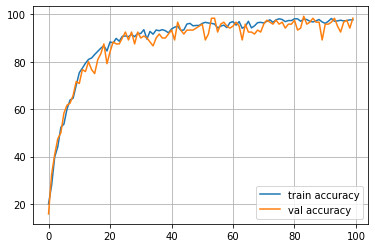

Finished Training


In [26]:
epochs = 100
# training(epochs, train_loader, val_loader, net, learning_rate)

In [13]:
PATH = './dataset/DeepEmotion_RETRAINED.pth'

# UNCOMMENT THE FOLLOWING COMMAND TO SAVE THE NEW TRAINED PARAMETERS
# torch.save(net.state_dict(), PATH)

In [14]:
# LOAD THE PRETRAINED NETWORK AFTER TRANSFERT LEARNING ON THE NEW DATASET

net = Deep_Emotion()
torch.device('cpu')
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

net.load_state_dict(torch.load(PATH, map_location=map_location))

<All keys matched successfully>

Accuracy of the retrained network on the new dataset

In [15]:
acc = accuracy(val_loader, net)
print('Accuracy of the network on the val images: %d %%' % acc)

C:\Users\Yacin\anaconda3\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\Yacin\anaconda3\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Accuracy of the network on the val images: 99 %


In [16]:
multi_class_accuracy(val_loader, net)

Accuracy of 😁: 100.00%
Accuracy of 😳: 100.00%
Accuracy of ☹️: 100.00%
Accuracy of 😗: 100.00%
Accuracy of 🙄: 100.00%
Accuracy of 😊: 100.00%
Accuracy of 😜: 100.00%


In [17]:
show_prediction('test.jpg', net)

Probability of 😁: 98.00%
Probability of 😳: 0.00%
Probability of ☹️: 0.00%
Probability of 😗: 0.00%
Probability of 🙄: 0.00%
Probability of 😊: 1.00%
Probability of 😜: 0.00%


In [37]:
# UNCOMMENT THE FOLLOWING COMMAND TO TEST THE PROGRAM WITH THE CAMERA

# show_prediction_video(net)